# A deep learning based controller design using deep deterministic policy gradient (DDPG)

##### The DDPG network design is derived from:
##### Deep Deterministic Policy Gradient (DDPG), Author: [amifunny](https://github.com/amifunny)$~~~~~$https://github.com/amifunny

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as ode
# system specifications
num_states = 2
num_actions = 1
# control signal(action) bounds
upper_bound = 20
lower_bound = -20

# Noise for DDPG Agent Exploration

In [2]:
# will be used for the DDPG exploration by adding it to the DDPG action
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.1, dt=0.1, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

# Replay Buffer
This class is used to store DDPG agent experience, and update the DDPG network using a batch of those stored data.

In [3]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.d_buffer = np.zeros((self.buffer_capacity, 1))

    # stores (state,aaction,reward,next state,episode status(ended or not)) obervation tuple
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.d_buffer[index] = obs_tuple[4]
        self.buffer_counter += 1
        
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch, d_batch
    ):
        # Training and updating Actor & Critic networks.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * tf.math.multiply(d_batch,    target_critic(
                [next_state_batch, target_actions], training=True)   )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)
        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        d_batch = tf.convert_to_tensor(self.d_buffer[batch_indices])
        d_batch = tf.cast(d_batch, dtype=tf.float32)
        self.update(state_batch, action_batch, reward_batch, next_state_batch,d_batch)
        target_actions = target_actor(next_state_batch, training=True)
        y = reward_batch + gamma * tf.math.multiply(d_batch,    target_critic(   [next_state_batch, target_actions], training=True)   )
        critic_value = critic_model([state_batch, action_batch], training=True)
        self.critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        actions = actor_model(state_batch, training=True)
        critic_value = critic_model([state_batch, actions], training=True)
        self.actor_loss = -tf.math.reduce_mean(critic_value)

@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

# Network Structure

In [4]:
from keras.layers import Lambda
from keras import backend as K
from tensorflow.keras.layers import Reshape
global t
t = 0.0
def sign_func(a): # used for implementing a custom output layer
    w = 1.0
    m = 1
    s1 = tf.gather(a, 0, axis=1)
    s2 = tf.gather(a, 1, axis=1)
    b = s1 + s2
    return m*K.sign(tf.reduce_sum(a,axis=1))

def sum_out(input): # used for implementing a custom output layer
    return tf.reduce_sum(input,axis=1)

def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.01, maxval=0.01)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(512, activation="relu")(inputs)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dense(64, activation="relu")(out)
    output1 = layers.Dense(1, activation="linear", kernel_initializer=last_init)(out)
    output2 = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    output3 = Lambda(sign_func)(inputs)
    output3 = Reshape((1,))(output3)
    output3 = tf.keras.layers.Multiply()([output2,output3])
    output = layers.Concatenate()([output1, output3])
    output = Lambda(sum_out)(output) # used for implementing a custom output layer
    output = Reshape((1,))(output)
    model = tf.keras.Model(inputs, output)
    return model

def get_critic():
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(512, activation="relu")(state_input)
    state_out = layers.Dense(512, activation="relu")(state_out)
    state_out = layers.Dense(512, activation="relu")(state_out)
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(512, activation="relu")(action_input)
    action_out = layers.Dense(512, activation="relu")(action_out)
    action_out = layers.Dense(512, activation="relu")(action_out)
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(512, activation="relu")(concat)
    out = layers.Dense(512, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action for better exploration
    sampled_actions = sampled_actions.numpy() + noise
    # The action should be kept between its allowed bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

def policy1(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to action
    sampled_actions = sampled_actions.numpy()
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

### hyperparameters

In [5]:

std_dev = 0.1
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()
target_actor = get_actor()
target_critic = get_critic()
# equal intial etwork weights
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())
# Learning rates
critic_lr = 0.005
actor_lr = 1 * 10**(-4)
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
# maximum number of episodes for the learning process
total_episodes = 1000
# Discount factor for future rewards 
# (since it is episodic, it is alright to choose 1 as discount factor)
gamma = 1.0
# target networks update rate
tau = 0.005

buffer = Buffer(60000, 70)

# Simplified System VS Original System without DDPG

Comparing the simplified system and original system with a controller designed for simplified system (beofre engaging DDPG)

(0.0, 150.0)

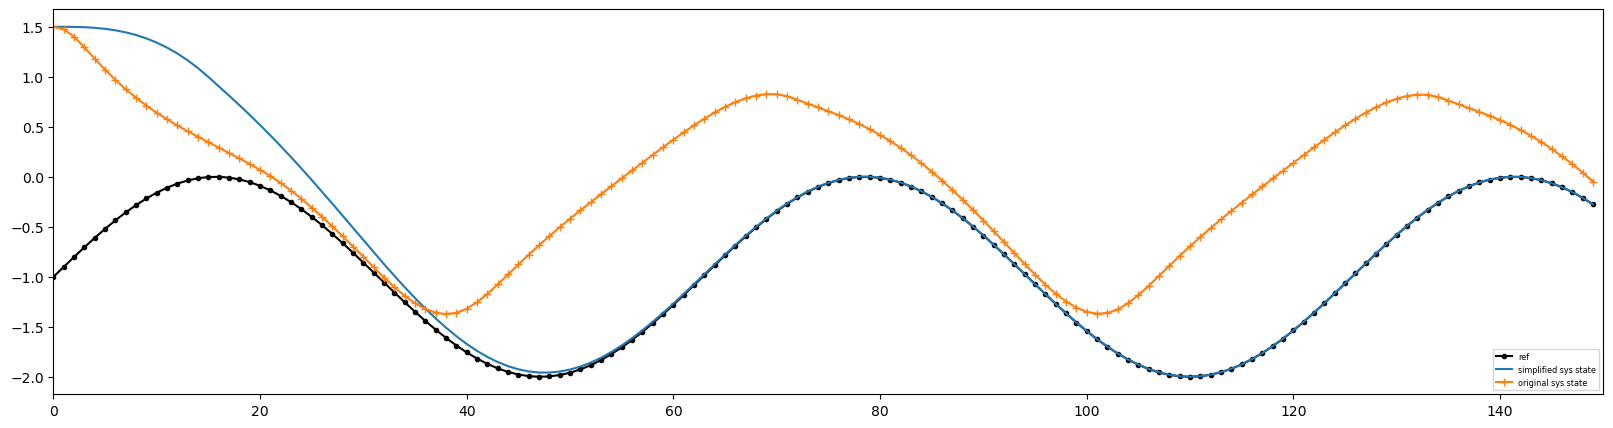

In [6]:
def sys1(t, y): # simplified system model (known model)
    s1, s2 = y
    c = 2
    k = 5
    b = 1.5
    m = 1
    w = 1
    u = m* (-s2 + w*np.cos(w*t)-w*w*np.sin(w*t)+k/m*s1+c/m*s2) - np.sign(1+s1-np.sin(w*t)+s2-w*np.cos(w*t))*m
    dydt = [s2, 1/m*(-c*s2-k*s1 + u)]
    return dydt

def sys2(t, y): # original system model (actual model)
    s1, s2 = y
    c = 2
    k = 5
    b = 1.5
    m = 1
    w = 1
    u = m* (-s2 + w*np.cos(w*t)-w*w*np.sin(w*t)+k/m*s1+c/m*s2) - np.sign(1+s1-np.sin(w*t)+s2-w*np.cos(w*t))*m
    dydt = [s2, 1/m*(-c*s2*np.abs(s2)-k*s1 - b*np.power(s1,3) + u)]
    return dydt
###############################################################################################################
initial_states = np.array([1.5,0])
s0 = initial_states

s_ref = []
u_ref = []
y_ref = []
c = 2
k = 5
b = 1.5
m = 1
w = 1
for i in range(150):
    t = i*0.1
    s_ref.append(s0)
    s1 = s_ref[-1][0]
    s2 = s_ref[-1][1]
    y_ref.append(-1+np.sin(w*t))
    u_ref.append (  m* (-s2 + w*np.cos(w*t)-w*w*np.sin(w*t)+k/m*s1+c/m*s2) - np.sign(1+s1-np.sin(w*t)+s2-w*np.cos(w*t))*m   )
    s0 = ode.solve_ivp(sys1, [t, t+0.1], s0, \
                               method = "RK45",t_eval=[t+0.1])
    s0 = s0.y[:,-1]
    
s0 = initial_states
s_ref2=[]
for i in range(150):
    t = i*0.1
    s_ref2.append(s0)
    s0 = ode.solve_ivp(sys2, [t, t+0.1], s0, \
                               method = "RK45",t_eval=[t+0.1])
    s0 = s0.y[:,-1]
# plotting comparision between simplified and original systems behavior
plt.figure(figsize=(20,5))
plt.plot(range(len(y_ref)),y_ref,color='k',marker='.', label="ref")
plt.plot(range(len(s_ref)),np.array(s_ref)[: , 0],label="simplified sys state")
plt.plot(range(len(s_ref2)),np.array(s_ref2)[: , 0],marker="+",label="original sys state")
plt.legend(loc='lower right',fontsize='xx-small')
plt.xlim(0, 150)

In the above figure, the the simplified system state (blue) is capable of following the desired behavior (black) while the original system state (orange) cannot follow the desired behavior. The reason is that the controller is designed based on the simplified system while there exists mismatch between original system and the symplified model.

The goal of the proposed deep learning based controller is for the states of the error system to converge to zero quickly by leveraging DDPG to compensate for the mismatch between original system and the symplified model.

# main

In [7]:
#reward/step for each episode
ep_reward_list = []
def sys(t, y):
    s1, s2 = y
    c = 2
    k = 5
    b = 1.5
    m = 1
    w = 1
    u = (  m* (-s2 + w*np.cos(w*t)-w*w*np.sin(w*t)+k/m*s1+c/m*s2) - np.sign(1+s1-np.sin(w*t)+s2-w*np.cos(w*t))*m   ) + action[0]
    dydt = [s2, 1/m*(-c*s2*np.abs(s2)-k*s1 - b*np.power(s1,3) + u)]
    return dydt

c = 2
k = 5
b = 1.5
m = 1
w = 1
ep = 0
# loop for running predefined number of episodes
while ep < total_episodes:
    prev_state = initial_states
    episodic_reward = 0
    numstep = 0
    avg_act = []
    break_flag = 0
    # episodic learning loop
    while True:
        t = numstep*0.1
        if np.isnan(prev_state).any()==True:
            print('prev_state is nan')
            break
            break_flag = 1
            ep = total_episodes
        elif np.isinf(prev_state).any()==True:
            print('prev_state is inf')
            break
            break_flag = 1
            ep = total_episodes
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state-s_ref[numstep]), 0)
        action = policy(tf_prev_state, ou_noise)
        avg_act.append(action)
        if np.isnan(action).any()==True:
            print('action is nan')
            break
            break_flag = 1
            ep = total_episodes
        elif np.isinf(action).any()==True:
            print('action is inf')
            break
            break_flag = 1
            ep = total_episodes
        y0 = ode.solve_ivp(sys, [t, t+0.1], prev_state, \
                               method = "RK45",t_eval=[t+0.1])
        state = y0.y[:,-1]
        if np.isnan(state).any()==True:
            print('state is nan')
            break
            break_flag = 1
            ep = total_episodes
        elif np.isinf(state).any()==True:
            print('state is inf')
            break
            break_flag = 1
            ep = total_episodes
        # Reward at each state is defined as the squred difference
        # of the original system and nominal system states.
        reward = -(   (state[0]-s_ref[numstep][0])**2 + (state[1]-s_ref[numstep][1] )**2     )
        episodic_reward += reward
        if np.isnan(reward).any()==True:
            print('reward is nan')
            break
            ep = total_episodes
        elif np.isinf(reward).any()==True:
            print('reward is inf')
            break
            break_flag = 1
            ep = total_episodes
        if episodic_reward <= -20 or numstep>=70:
            d_stat = np.array([0])
        else:
            d_stat = np.array([1])
        buffer.record((  prev_state-s_ref[numstep]    , action, reward,  state-s_ref[numstep+1], d_stat ))
        buffer.learn()
        if break_flag ==0:
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
        # End this episode if episodic reward is lower than a threshold, 
        #or the simulation is reached to a predefined time
        if episodic_reward <= -20 or numstep>=70:
            break
        prev_state = state
        numstep+=1
    ep_reward_list.append(episodic_reward/numstep)
    ep+=1
    avg_act = np.array(avg_act)
    print('------------------------------------------------------------------------------------------------------')
    print("Episode * {} *".format(ep))
    print(" Episodic Reward per numstep is ==> {}".format(ep_reward_list[-1]))
    print ('critic_loss >>>' , buffer.critic_loss.numpy() , '    actor_loss >>>' , buffer.actor_loss.numpy()\
          , '|    avg action',np.mean(avg_act,0))
    if np.isnan(buffer.critic_loss.numpy()).any()==True or np.isnan(buffer.actor_loss.numpy()).any()==True:
        ep = total_episodes
    # if the episodic reward is above a threshold, the results are acceptable
    # and can terminate the learning proces
    if np.abs((ep_reward_list[-1])) <0.028 and numstep>=70 and ep>=100:
        ep = 100000

------------------------------------------------------------------------------------------------------
Episode * 1 *
 Episodic Reward per numstep is ==> -0.5529215394305222
critic_loss >>> 0.015965404     actor_loss >>> 0.73149365 |    avg action [-0.16876933]
------------------------------------------------------------------------------------------------------
Episode * 2 *
 Episodic Reward per numstep is ==> -0.6271983989454866
critic_loss >>> 0.00065311283     actor_loss >>> 0.68222916 |    avg action [-0.1555128]
------------------------------------------------------------------------------------------------------
Episode * 3 *
 Episodic Reward per numstep is ==> -0.5533577246959139
critic_loss >>> 0.00093273044     actor_loss >>> 0.8792443 |    avg action [-0.03475475]
------------------------------------------------------------------------------------------------------
Episode * 4 *
 Episodic Reward per numstep is ==> -0.5307927238544916
critic_loss >>> 0.016596228     actor_loss

------------------------------------------------------------------------------------------------------
Episode * 33 *
 Episodic Reward per numstep is ==> -0.17965096050772614
critic_loss >>> 0.49621668     actor_loss >>> 2.6139357 |    avg action [-1.14432369]
------------------------------------------------------------------------------------------------------
Episode * 34 *
 Episodic Reward per numstep is ==> -0.14418510012083313
critic_loss >>> 0.2769458     actor_loss >>> 2.1686947 |    avg action [-1.10799262]
------------------------------------------------------------------------------------------------------
Episode * 35 *
 Episodic Reward per numstep is ==> -0.31367753162850615
critic_loss >>> 0.2898801     actor_loss >>> 2.6499524 |    avg action [-2.0942377]
------------------------------------------------------------------------------------------------------
Episode * 36 *
 Episodic Reward per numstep is ==> -0.23972940706491194
critic_loss >>> 0.16057357     actor_loss >>>

------------------------------------------------------------------------------------------------------
Episode * 65 *
 Episodic Reward per numstep is ==> -0.2155684543902773
critic_loss >>> 0.045261167     actor_loss >>> 3.340301 |    avg action [-0.4597996]
------------------------------------------------------------------------------------------------------
Episode * 66 *
 Episodic Reward per numstep is ==> -0.23655614173763767
critic_loss >>> 0.37801978     actor_loss >>> 3.6812077 |    avg action [-0.49746057]
------------------------------------------------------------------------------------------------------
Episode * 67 *
 Episodic Reward per numstep is ==> -0.21543330347456022
critic_loss >>> 0.0820614     actor_loss >>> 3.2409012 |    avg action [-0.43342229]
------------------------------------------------------------------------------------------------------
Episode * 68 *
 Episodic Reward per numstep is ==> -0.26970790868819183
critic_loss >>> 0.6863177     actor_loss >>> 

------------------------------------------------------------------------------------------------------
Episode * 97 *
 Episodic Reward per numstep is ==> -0.23424530644759695
critic_loss >>> 0.6573698     actor_loss >>> 4.784754 |    avg action [-1.11883102]
------------------------------------------------------------------------------------------------------
Episode * 98 *
 Episodic Reward per numstep is ==> -0.22948662324428046
critic_loss >>> 0.7049001     actor_loss >>> 4.623172 |    avg action [-1.43261444]
------------------------------------------------------------------------------------------------------
Episode * 99 *
 Episodic Reward per numstep is ==> -0.22481326049976222
critic_loss >>> 0.10402146     actor_loss >>> 4.6109533 |    avg action [-1.3110291]
------------------------------------------------------------------------------------------------------
Episode * 100 *
 Episodic Reward per numstep is ==> -0.2156825309837372
critic_loss >>> 0.076224685     actor_loss >>> 

------------------------------------------------------------------------------------------------------
Episode * 129 *
 Episodic Reward per numstep is ==> -0.3137064414499123
critic_loss >>> 0.91302294     actor_loss >>> 5.1673813 |    avg action [-1.79141775]
------------------------------------------------------------------------------------------------------
Episode * 130 *
 Episodic Reward per numstep is ==> -0.22477756043705371
critic_loss >>> 0.38878223     actor_loss >>> 5.5106835 |    avg action [-1.1492583]
------------------------------------------------------------------------------------------------------
Episode * 131 *
 Episodic Reward per numstep is ==> -0.21085925730977767
critic_loss >>> 0.85074055     actor_loss >>> 5.2631946 |    avg action [-1.36230387]
------------------------------------------------------------------------------------------------------
Episode * 132 *
 Episodic Reward per numstep is ==> -0.2096639955414894
critic_loss >>> 0.38664135     actor_loss

------------------------------------------------------------------------------------------------------
Episode * 161 *
 Episodic Reward per numstep is ==> -0.17371129733594617
critic_loss >>> 0.18492483     actor_loss >>> 6.177763 |    avg action [-1.59491832]
------------------------------------------------------------------------------------------------------
Episode * 162 *
 Episodic Reward per numstep is ==> -0.1169413577817091
critic_loss >>> 0.85777724     actor_loss >>> 6.154972 |    avg action [-1.93237035]
------------------------------------------------------------------------------------------------------
Episode * 163 *
 Episodic Reward per numstep is ==> -0.12927410107823753
critic_loss >>> 1.8109602     actor_loss >>> 6.084276 |    avg action [-1.80679839]
------------------------------------------------------------------------------------------------------
Episode * 164 *
 Episodic Reward per numstep is ==> -0.28359037367959794
critic_loss >>> 1.6874305     actor_loss >>

------------------------------------------------------------------------------------------------------
Episode * 193 *
 Episodic Reward per numstep is ==> -1.140913408800409
critic_loss >>> 2.6737242     actor_loss >>> 10.893915 |    avg action [-0.70883987]
------------------------------------------------------------------------------------------------------
Episode * 194 *
 Episodic Reward per numstep is ==> -1.333506281376969
critic_loss >>> 0.29951558     actor_loss >>> 10.172204 |    avg action [2.38386028]
------------------------------------------------------------------------------------------------------
Episode * 195 *
 Episodic Reward per numstep is ==> -0.5615699721293289
critic_loss >>> 1.7850664     actor_loss >>> 7.4717565 |    avg action [-1.01955956]
------------------------------------------------------------------------------------------------------
Episode * 196 *
 Episodic Reward per numstep is ==> -2.273136242636537
critic_loss >>> 0.76998806     actor_loss >>> 7.

------------------------------------------------------------------------------------------------------
Episode * 225 *
 Episodic Reward per numstep is ==> -0.12445190885890778
critic_loss >>> 0.18868104     actor_loss >>> 7.5026426 |    avg action [-1.39153416]
------------------------------------------------------------------------------------------------------
Episode * 226 *
 Episodic Reward per numstep is ==> -0.07506278695400789
critic_loss >>> 1.4574862     actor_loss >>> 7.55941 |    avg action [-1.85394497]
------------------------------------------------------------------------------------------------------
Episode * 227 *
 Episodic Reward per numstep is ==> -0.09369405628618155
critic_loss >>> 0.52942455     actor_loss >>> 7.8213983 |    avg action [-1.8457348]
------------------------------------------------------------------------------------------------------
Episode * 228 *
 Episodic Reward per numstep is ==> -0.10163164822048083
critic_loss >>> 1.1928895     actor_loss >

------------------------------------------------------------------------------------------------------
Episode * 257 *
 Episodic Reward per numstep is ==> -0.11844295085884285
critic_loss >>> 0.941961     actor_loss >>> 7.5862155 |    avg action [-2.1443848]
------------------------------------------------------------------------------------------------------
Episode * 258 *
 Episodic Reward per numstep is ==> -0.11817356362443492
critic_loss >>> 0.9144537     actor_loss >>> 7.8565392 |    avg action [-1.54589878]
------------------------------------------------------------------------------------------------------
Episode * 259 *
 Episodic Reward per numstep is ==> -0.12296980277271892
critic_loss >>> 1.6771561     actor_loss >>> 7.680098 |    avg action [-1.41975859]
------------------------------------------------------------------------------------------------------
Episode * 260 *
 Episodic Reward per numstep is ==> -0.1157221122266732
critic_loss >>> 2.807689     actor_loss >>> 7

------------------------------------------------------------------------------------------------------
Episode * 289 *
 Episodic Reward per numstep is ==> -0.08020882569683141
critic_loss >>> 0.2869458     actor_loss >>> 6.902034 |    avg action [-1.30725312]
------------------------------------------------------------------------------------------------------
Episode * 290 *
 Episodic Reward per numstep is ==> -0.0689158109992171
critic_loss >>> 0.8526772     actor_loss >>> 7.023117 |    avg action [-1.34484257]
------------------------------------------------------------------------------------------------------
Episode * 291 *
 Episodic Reward per numstep is ==> -0.06727474416393685
critic_loss >>> 0.25522256     actor_loss >>> 6.7635245 |    avg action [-1.4375155]
------------------------------------------------------------------------------------------------------
Episode * 292 *
 Episodic Reward per numstep is ==> -0.0676079747809375
critic_loss >>> 0.22422136     actor_loss >>>

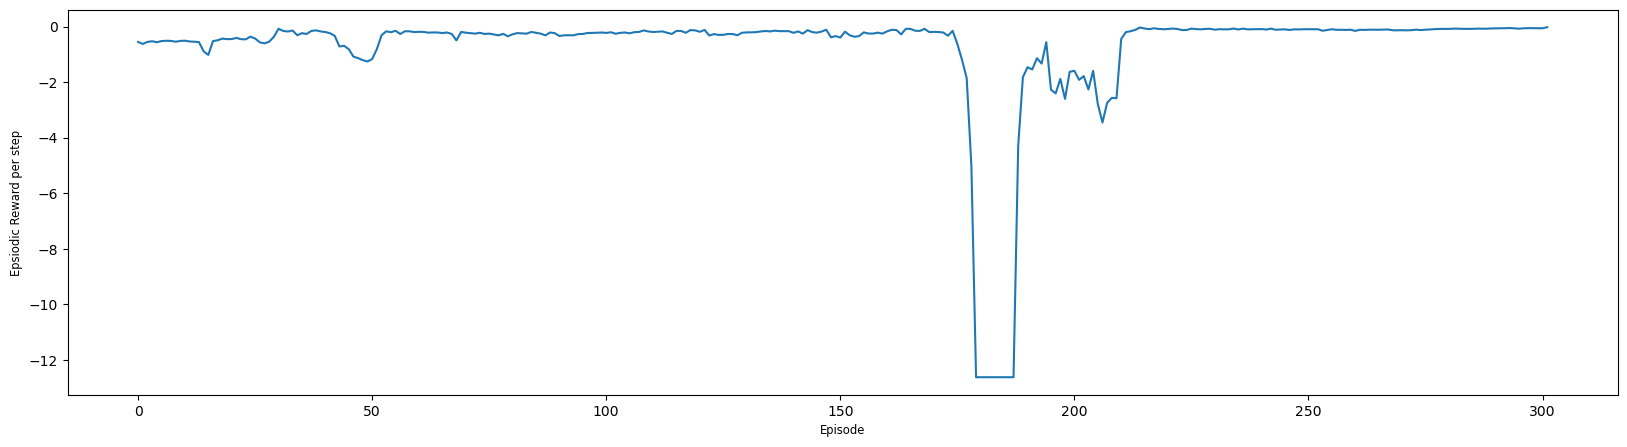

In [8]:
#plotting episodic reward
plt.figure(figsize=(20,5))
# plt.xlim(0, 180)
plt.plot(ep_reward_list)
plt.xlabel("Episode",fontsize='small')
plt.ylabel("Epsiodic Reward per step",fontsize='small')
plt.show()

As displayed here, the episodic reward/step converges, and the results below show the satisfactory performance of DDPG in compensating for the diffenrece between the original system and the simplified model.

# Evaluation Phase

In [9]:
prev_state = initial_states
SS=[]
numstep = 0
u = []
u_n = []
c = 2
k = 5
b = 1.5
m = 5
w = 1
while True:
    t = numstep*0.1
    SS.append(prev_state)
    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state-s_ref[numstep]), 0)

    action = policy1(tf_prev_state, ou_noise)
    y0 = ode.solve_ivp(sys, [t, t+0.1], prev_state, \
                           method = "RK45",t_eval=[t+0.1])
    state = y0.y[:,-1]
    s1 = state[0]
    s2 = state[1]
    u.append(  m* (-s2 + w*np.cos(w*t)-w*w*np.sin(w*t)+k/m*s1+c/m*s2) - np.sign(1+s1-np.sin(w*t)+s2-w*np.cos(w*t))*m )
    u_n.append(np.array(action))
    if numstep>=149 :
        break
    prev_state = state
    numstep+=1

In [10]:
size_1 = 32
size_2 = 24
size_3 = 24
plt.rc('font', size=size_2)          # controls default text sizes
plt.rc('axes', titlesize=size_3)     # fontsize of the axes title
plt.rc('axes', labelsize=size_1)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size_3)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size_3)    # fontsize of the tick labels
plt.rc('legend', fontsize=size_3)    # legend fontsize
plt.rc('figure', titlesize=size_2)  # fontsize of the figure title

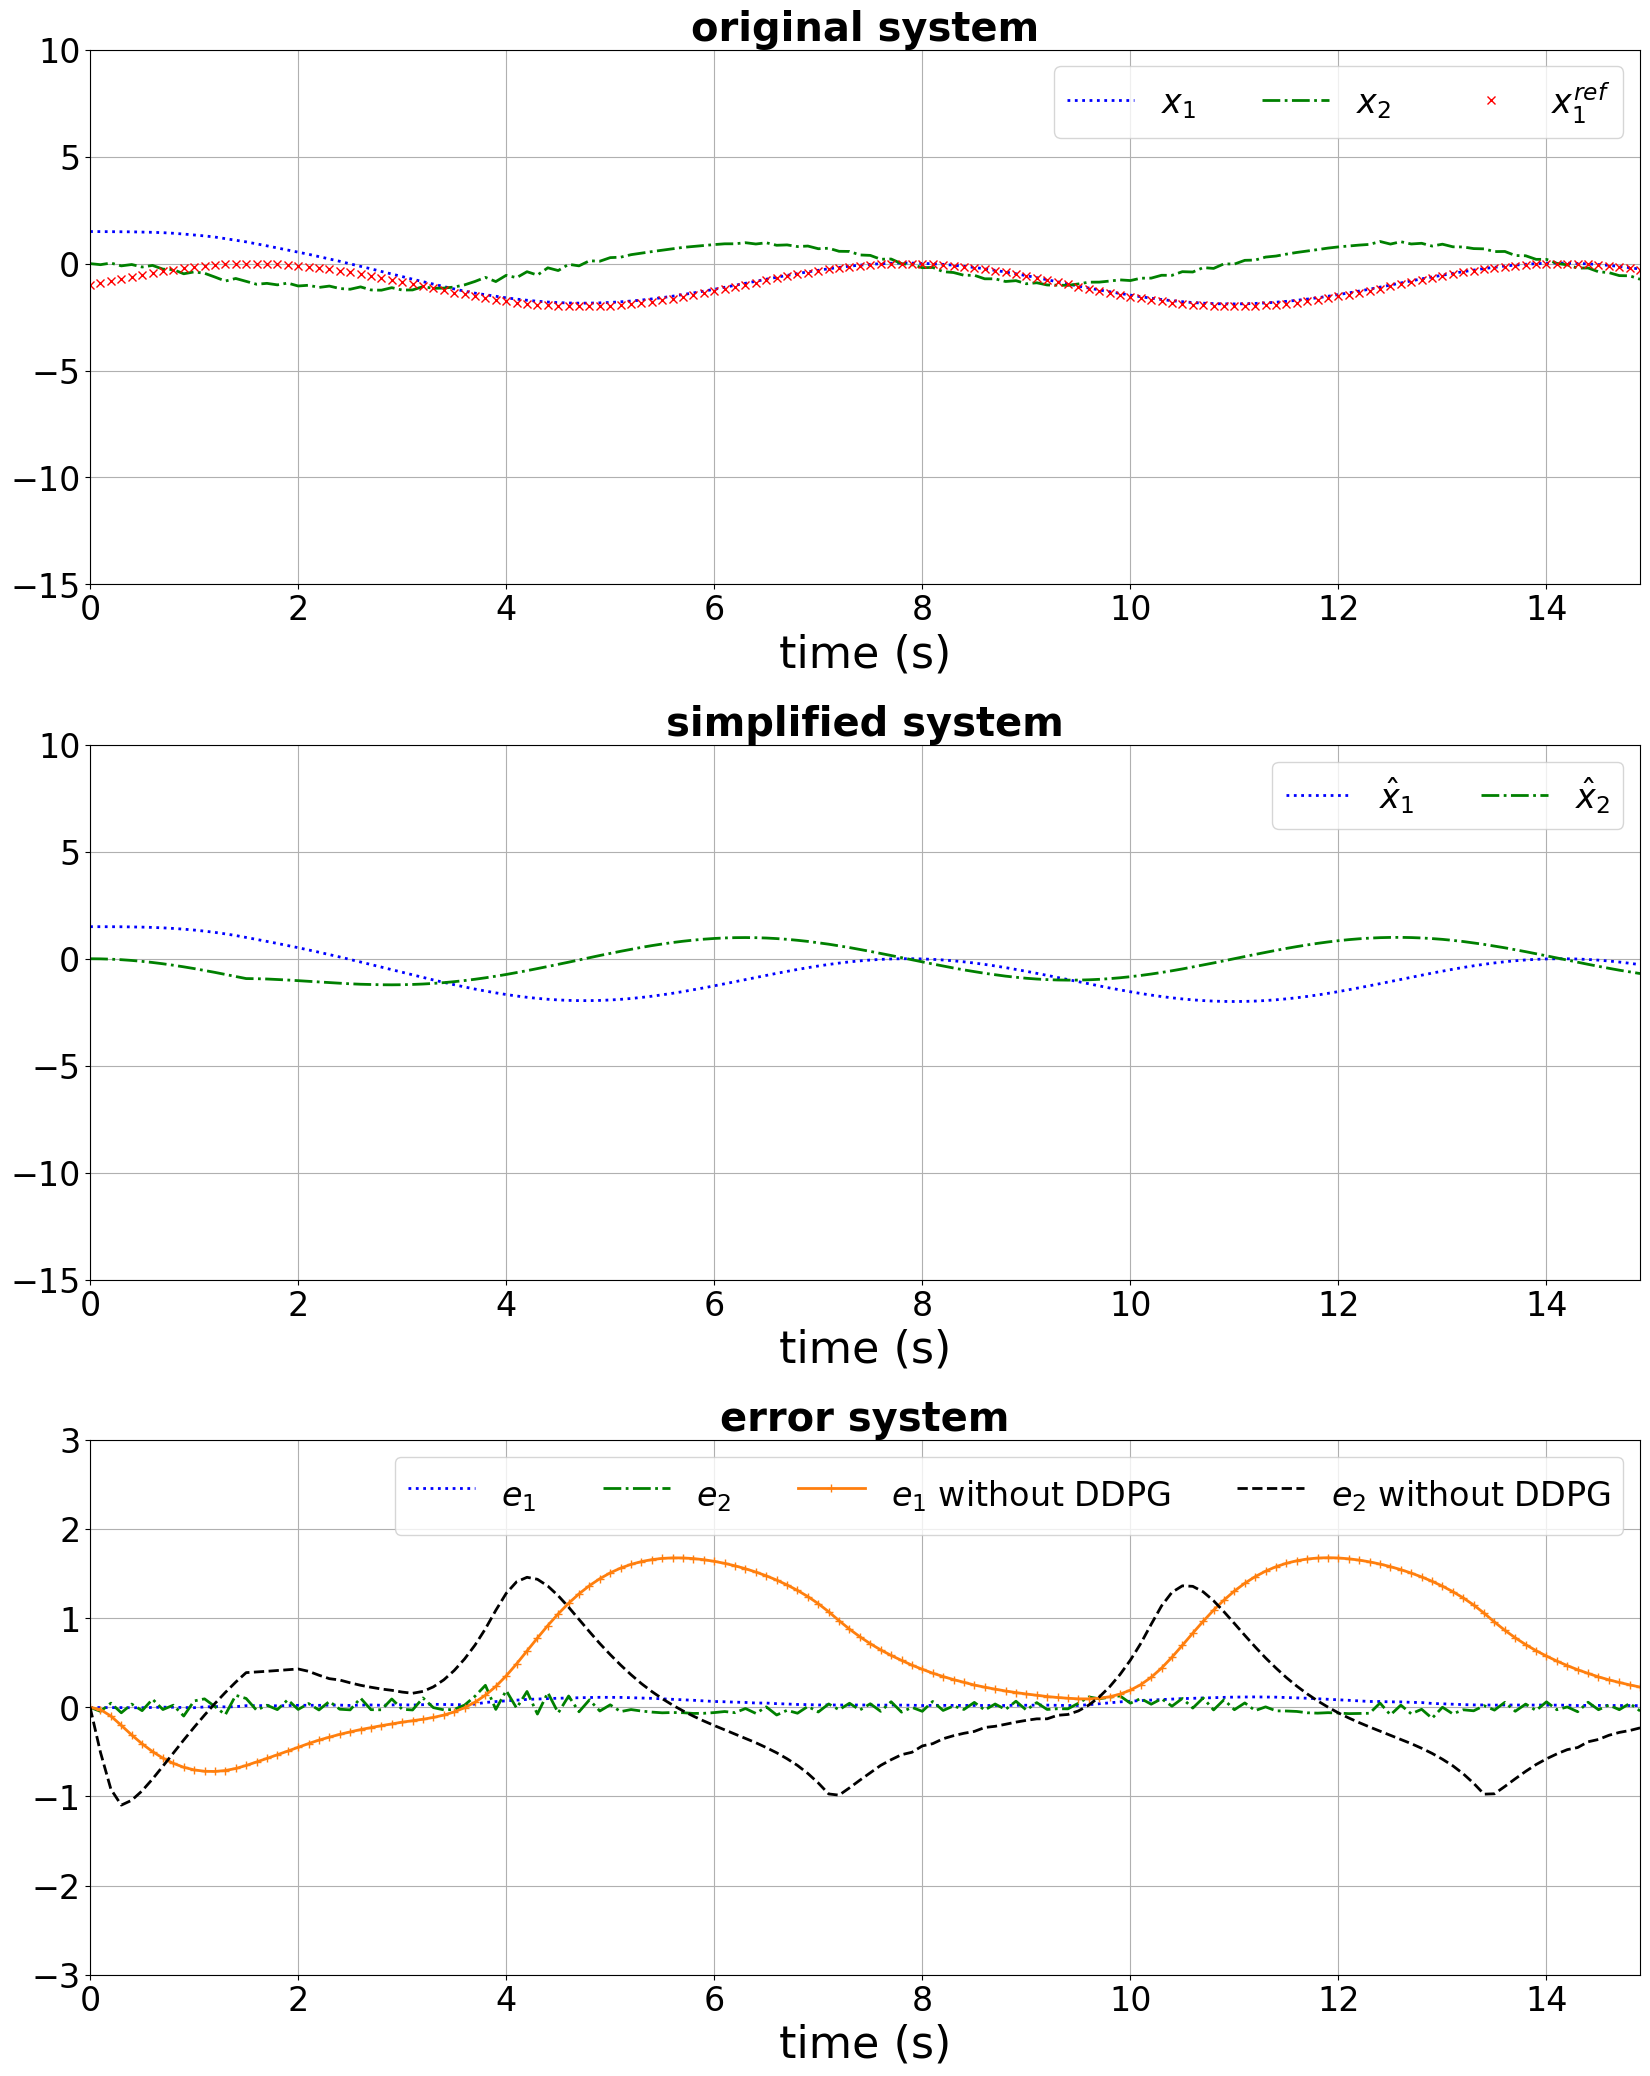

In [11]:
abcd = [':', '-.' ,'-','+-','--','x','*','3-', '|-']
abcd = [':', '-.' ,'+-','--','x','*','3-', '|-']
color1 = ['b' , 'g' , 'r' , 'tab:orange' , 'black' , 'mediumaquamarine' , 'deepskyblue' , 'tab:purple' , 'darkblue'  , 'darkred']
color1 = ['b' , 'g' , 'tab:orange' , 'black' , 'mediumaquamarine' , 'deepskyblue' , 'tab:purple' , 'darkblue'  , 'darkred']
fig, axs = plt.subplots(3,gridspec_kw={'height_ratios': [1, 1 , 1]})
x1 = np.arange(0,15,0.1)
SS = np.array(SS)
s_ref = np.array (s_ref)
s_ref2 = np.array(s_ref2)
fig.set_size_inches(20, 25)
###########################################################################
counter12 = 0
for i in range(2):
    s='$x_{%i}$' % (i+1)
    axs[0].plot(x1,SS[:,i],abcd[counter12],c=color1[counter12],linewidth=2,label=s)
    counter12+=1
# axs[0].plot(x1,u,abcd[counter12],c=color1[counter12],linewidth=2,label='$\hat{u}(\mathbf{x})$')
counter12+=1
# axs[0].plot(x1,u_n,abcd[counter12],c=color1[counter12],linewidth=2,label='$u_{1}$')
counter12+=1
axs[0].plot(x1,y_ref,abcd[counter12],c='r',linewidth=2,label='$x_{1}^{ref}$')
axs[0].set(xlabel='time (s)')
axs[0].set_xlim(x1[0],x1[-1])
axs[0].set_ylim(-15,10)
axs[0].grid()
axs[0].legend(ncol=10,handleheight=1,loc='upper right')
axs[0].set_title('original system',fontsize='large',fontweight='bold')
#############################################################################
counter12 = 0
for i in range(2):
    s='$\hat{x}_{%i}$' % (i+1)
    axs[1].plot(x1,s_ref[:,i],abcd[counter12],c=color1[counter12],linewidth=2,label=s)
    counter12+=1
# axs[1].plot(x1,u_ref,abcd[counter12],c=color1[counter12],linewidth=2,label='$\hat{u}(\mathbf{\hat{x}})$')
axs[1].set(xlabel='time (s)')
axs[1].set_xlim(x1[0],x1[-1])
axs[1].set_ylim(-15,10)
axs[1].grid()
axs[1].legend(ncol=3,handleheight=1,loc='upper right')
axs[1].set_title('simplified system',fontsize='large',fontweight='bold')
#############################################################################
counter12 = 0
#for i in range(2):
    #s='$e_{%i}$' % (i+1)
    #axs[2].plot(x1,SS[:,i]-s_ref[:,i],abcd[counter12],c=color1[counter12],linewidth=2,label=s)
    #counter12+=1
s='$e_{%i}$' % (1)
axs[2].plot(x1,SS[:,0]-s_ref[:,0],abcd[counter12],c=color1[counter12],linewidth=2,label=s)
counter12+=1
s='$e_{%i}$' % (2)
axs[2].plot(x1,SS[:,1]-s_ref[:,1],abcd[counter12],c=color1[counter12],linewidth=2,label=s)
counter12+=1
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
s='$e_{%i}$ without DDPG' % (1)
axs[2].plot(x1,s_ref2[:,0]-s_ref[:,0],abcd[counter12],c=color1[counter12],linewidth=2,label=s)
counter12+=1
s='$e_{%i}$ without DDPG' % (2)
axs[2].plot(x1,s_ref2[:,1]-s_ref[:,1],abcd[counter12],c=color1[counter12],linewidth=2,label=s)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
axs[2].set(xlabel='time (s)')
axs[2].set_xlim(x1[0],x1[-1])
axs[2].set_ylim(-3,3)
axs[2].grid()
axs[2].legend(ncol=4,handleheight=2,loc='upper right')
axs[2].set_title('error system',fontsize='large',fontweight='bold')
#############################################################################
plt.subplots_adjust(hspace=0.3)
plt.savefig('results.jpg',bbox_inches = 'tight')
# from google.colab import files
# files.download('results.jpg')

The first subplot shows original system states. The second subplot shows simplified system states, while the last subplot depicts error system states (the difference between simplified system states and the original system states). The goal of the proposed deep learning based controller is for the states of the error system to converge to zero quickly, which is achievd successfully.